## Ensemble Learning

In this notebook, we will compare the performance of:

- just re-sampling
- just boosting or bagging
- bagging + resamppling
- boosting + resampling
- bagging + boosting + resampling

Utilizing classes from sklearn and imbalanced learn, over various datasets.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
)

from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE

from imblearn.ensemble import (
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)

In [2]:
# just re-sampling methods (no classifier)

resampling_dict = {
    
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False,
    ),

    'smote': SMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        n_jobs=4,
    ),
}

In [3]:
# ensemble methods (with or without resampling)

ensemble_dict = {

    # balanced random forests (bagging)
    'balancedRF': BalancedRandomForestClassifier(
        n_estimators=20,
        criterion='gini',
        max_depth=3,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=2909,
    ),

    # bagging of Logistic regression, no resampling
    'bagging': BaggingClassifier(
        base_estimator=LogisticRegression(random_state=2909),
        n_estimators=20,
        n_jobs=4,
        random_state=2909,
    ),

    # bagging of Logistic regression, with resampling
    'balancedbagging': BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=2909),
        n_estimators=20,
        max_samples=1.0,  # The number of samples to draw from X to train each base estimator
        max_features=1.0,  # The number of features to draw from X to train each base estimator
        bootstrap=True,
        bootstrap_features=False,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=2909,
    ),

    # boosting + undersampling
    'rusboost': RUSBoostClassifier(
        base_estimator=None,
        n_estimators=20,
        learning_rate=1.0,
        sampling_strategy='auto',
        random_state=2909,
    ),

    # bagging + boosting + under-sammpling
    'easyEnsemble': EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=2909,
    ),
}

In [4]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=20, random_state=39, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [6]:
# function to train random forests and evaluate the peadaormance

def run_adaboost(X_train, X_test, y_train, y_test):

    ada = AdaBoostClassifier(n_estimators=20, random_state=2909)
    
    ada.fit(X_train, y_train)

    print('Train set')
    pred = ada.predict_proba(X_train)
    print(
        'AdaBoost roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = ada.predict_proba(X_test)
    print(
        'AdaBoost roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [7]:
# function to train random forests and evaluate the peensembleormance

def run_ensemble(ensemble, X_train, X_test, y_train, y_test):
    
    ensemble.fit(X_train, y_train)

    print('Train set')
    pred = ensemble.predict_proba(X_train)
    print(
        'ensembleBoost roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = ensemble.predict_proba(X_test)
    print(
        'ensembleBoost roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [8]:
# to save the results
results_dict = {}

for dataset in datasets_ls:
    
    results_dict[dataset] = {}    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    
    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,  
    data.target, 
    test_size=0.3,
    random_state=0)
    
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # train model and store result
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data'] = roc
    print()
    
    # train model and store result
    roc = run_adaboost(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data_adaboost'] = roc
    print()
    
    for sampler in resampling_dict.keys():
        
        print(sampler)
        
        # resample
        X_resampled, y_resampled = resampling_dict[sampler].fit_resample(X_train, y_train)
        
        # train model and store result
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        results_dict[dataset][sampler] = roc
        print()
    
    for ensemble in ensemble_dict.keys():
        
        print(ensemble)
        
        # train model and store result
        roc = run_ensemble(ensemble_dict[ensemble], X_train, X_test, y_train, y_test)
        results_dict[dataset][ensemble] = roc
        print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9513383050063591
Test set
Random Forests roc-auc: 0.9351974691295031

Train set
AdaBoost roc-auc: 0.9987040891047134
Test set
AdaBoost roc-auc: 0.9961985916930298

random
Train set
Random Forests roc-auc: 0.9808648398658805
Test set
Random Forests roc-auc: 0.9641289927543627

smote
Train set
Random Forests roc-auc: 0.9802530157629012
Test set
Random Forests roc-auc: 0.9637207878354934

balancedRF
Train set
ensembleBoost roc-auc: 0.9919499364088333
Test set
ensembleBoost roc-auc: 0.9923971833860598

bagging
Train set
ensembleBoost roc-auc: 0.9987281766678229
Test set
ensembleBoost roc-auc: 0.9969894887233391

balancedbagging
Train set
ensembleBoost roc-auc: 0.9980440898755155
Test set
ensembleBoost roc-auc: 0.9962751301153179

rusboost
Train set
ensembleBoost roc-auc: 0.9975286160249739
Test set
ensembleBoost roc-auc: 0.9960455148484539

easyEnsemble
Train set
ensembleBoost roc-auc: 0.9983813157590472
Test set
ensembleBoost roc-auc: 0.9955

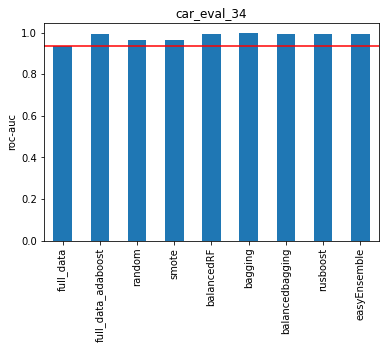

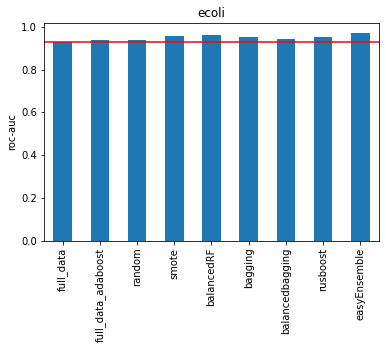

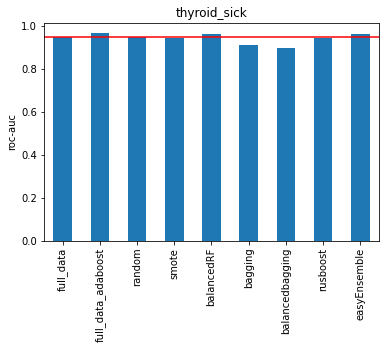

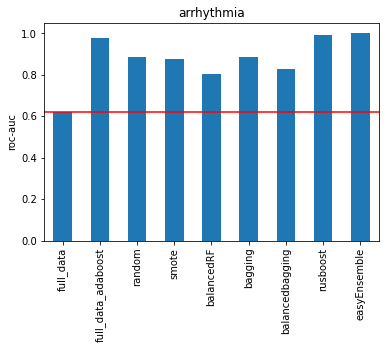

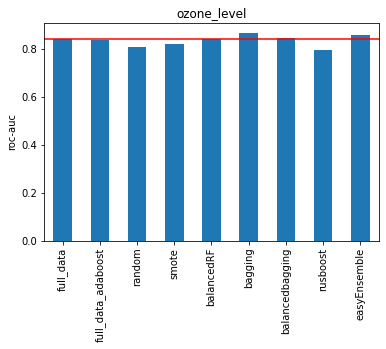

In [9]:
for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

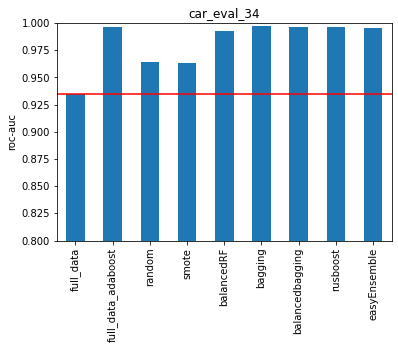

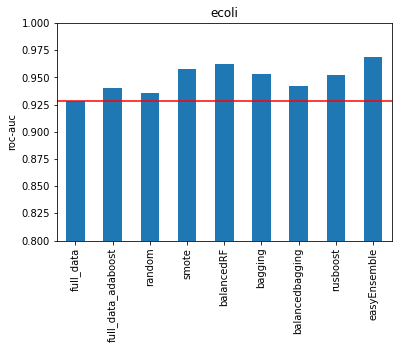

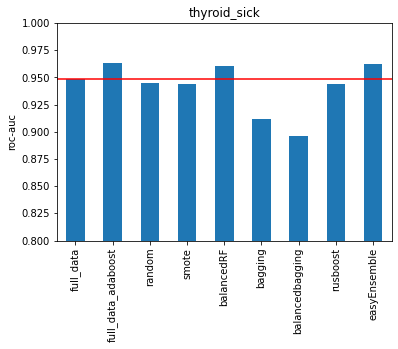

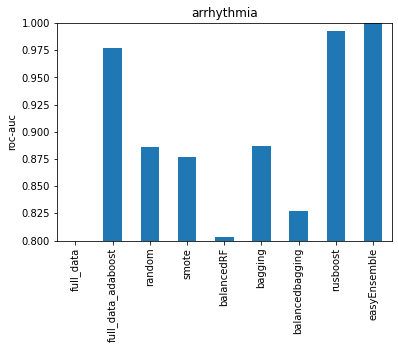

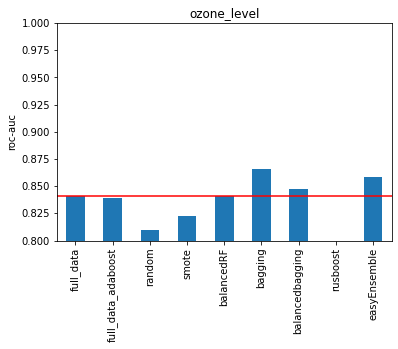

In [10]:
for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.8, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

We see that boosting algorithms tend to outperform bagging algorithms. And adding resampling to bagging improves performance, in general, quite a bit.

Note that here, I am comparing the vanilla models for each ensemble. If we put some time into optimising the parameters, surely, we could get better models for each one of these implementations. I leave that as a homework to you.
